# Image Captioning with CNN-LSTM architecture

In [ ]:
import re
import string
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from tensorflow.keras.regularizers import L2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model,save_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.applications.xception import Xception,preprocess_input
from tensorflow.keras.layers import Dense,Concatenate,LSTM,Embedding,Input,add,Dropout,BatchNormalization

### Loading Data and Preprocessing 

In [3]:
# loading the data into a list
captions_list=[]
with open('/kaggle/input/flickr8k/captions.txt','r') as file:
    for line in file:
        captions_list.append(line)

captions_list.pop(0)
captions_list[0],captions_list[100],len(captions_list)

('1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1024138940_f1fefbdce1.jpg,Two different breeds of brown and white dogs play on the beach .\n',
 40455)

In [4]:
# shuffling the list and then splitting it into train and test set
def split_array_randomly(array, split_ratio=0.85):
    np.random.shuffle(array)
    
    split_index = int(len(array) * split_ratio)
    array1 = array[:split_index]
    array2 = array[split_index:]
    
    return list(array1), list(array2)

cap_list_train, cap_list_test = split_array_randomly(np.array(captions_list))

In [53]:
# creating dictionary 
# the key will be image name and value will be the list of captions
# value is a list of captions as multiple captions are given for a single photo
cap_dict_train = {}
for line in cap_list_train:
    try:
        img , cap =  line.split(',')
        if img not in cap_dict_train:
            cap_dict_train[img]=[]
        cap_dict_train[img].append(cap)
    except:
        continue

cap_dict_test = {}
for line in cap_list_test:
    try:
        img , cap =  line.split(',')
        if img not in cap_dict_test:
            cap_dict_test[img]=[]
        cap_dict_test[img].append(cap)
    except:
        continue

In [6]:
# text cleaning 
def clean_text(dict_):
    for img,caps in dict_.items():
        for i in range(len(caps)):
            cap = caps[i]
            text = cap.lower()
            cleaned_text = re.sub(r'\n', '', text)
            # removing punctuation
            cleaned_text = re.sub(r'[^A-Za-z ]','',cleaned_text)
            # removing the word 'a' as a stopword
            cleaned_text = re.sub(r'\ba\b','',cleaned_text)
            # adding the sos(start of sentence) and eos(end of sentence) token
            cleaned_text = 'sos ' + cleaned_text + ' eos'
            caps[i] = cleaned_text

In [7]:
clean_text(cap_dict_train)

## Image encoding using VGG16

In [8]:
vgg_model=VGG16()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [12]:
vgg_model=Model(inputs=vgg_model.input,outputs=vgg_model.layers[-2].output)

In [10]:
img_enc={}
for im in tqdm(list(cap_dict_train.keys())):
    img=image.load_img('/kaggle/input/flickr8k/Images/'+str(im),target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    img_enc[im]=vgg_model.predict(x,verbose=0).reshape((4096,))

"img_enc={}\nfor im in tqdm(list(cap_dict_train.keys())):\n    img=image.load_img('/kaggle/input/flickr8k/Images/'+str(im),target_size=(224, 224))\n    x = image.img_to_array(img)\n    x = np.expand_dims(x, axis=0)\n    x = preprocess_input(x)\n    img_enc[im]=vgg_model.predict(x,verbose=0).reshape((4096,))"

In [23]:
with open('/kaggle/working/encoding_train_vgg.pkl','wb') as f:
    pickle.dump(img_enc,f)

In [10]:
with open('/kaggle/input/encodingg/encoding_train_vgg.pkl','rb') as f:
    img_enc = pickle.load(f)

## Setting up the Tokenizer

In [13]:
corpus=[]
for img,caps in cap_dict_train.items():
    for cap in caps:
        corpus.append(cap)

In [14]:
tokenizer=Tokenizer(oov_token='<unk>')
tokenizer.fit_on_texts(corpus)
vocab_len=len(tokenizer.word_index)+1
vocab_len

7911

In [15]:
seq_lens=[len(cap.split(' ')) for cap in corpus]
max(seq_lens),min(seq_lens)

(36, 3)

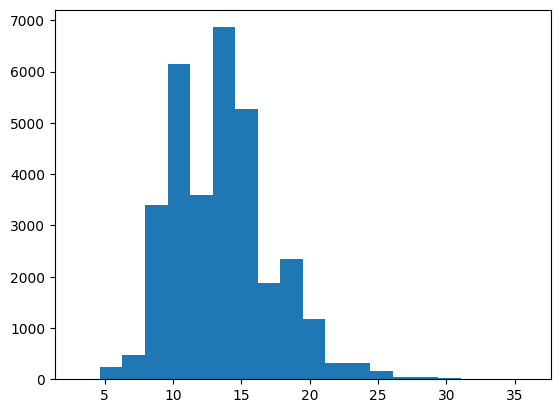

In [16]:
plt.hist(seq_lens,bins=20)
plt.show()

## Creating a Data Generator

In [17]:

def data_generator(img_enc, mapping,tokenizer, max_length, vocab_length, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in img_enc.keys():
            try:
                captions = mapping[key]
            except:
                continue
            n += 1
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_length)[0]
                    
                    # store the sequences
                    X1.append(img_enc[key])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

## Defing the Model Architecture

In [20]:
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
img1 = Dropout(0.4)(inputs1)
img2 = Dense(256, activation='relu')(img1)

#sequence feature layers
inputs2 = Input(shape=(26,), name="text")
seq1 = Embedding(vocab_len, 256, mask_zero=True)(inputs2)
seq2 = Dropout(0.4)(seq1)
seq3 = LSTM(256)(seq2)

# decoder model
decoder1 = add([img2, seq3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_len, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

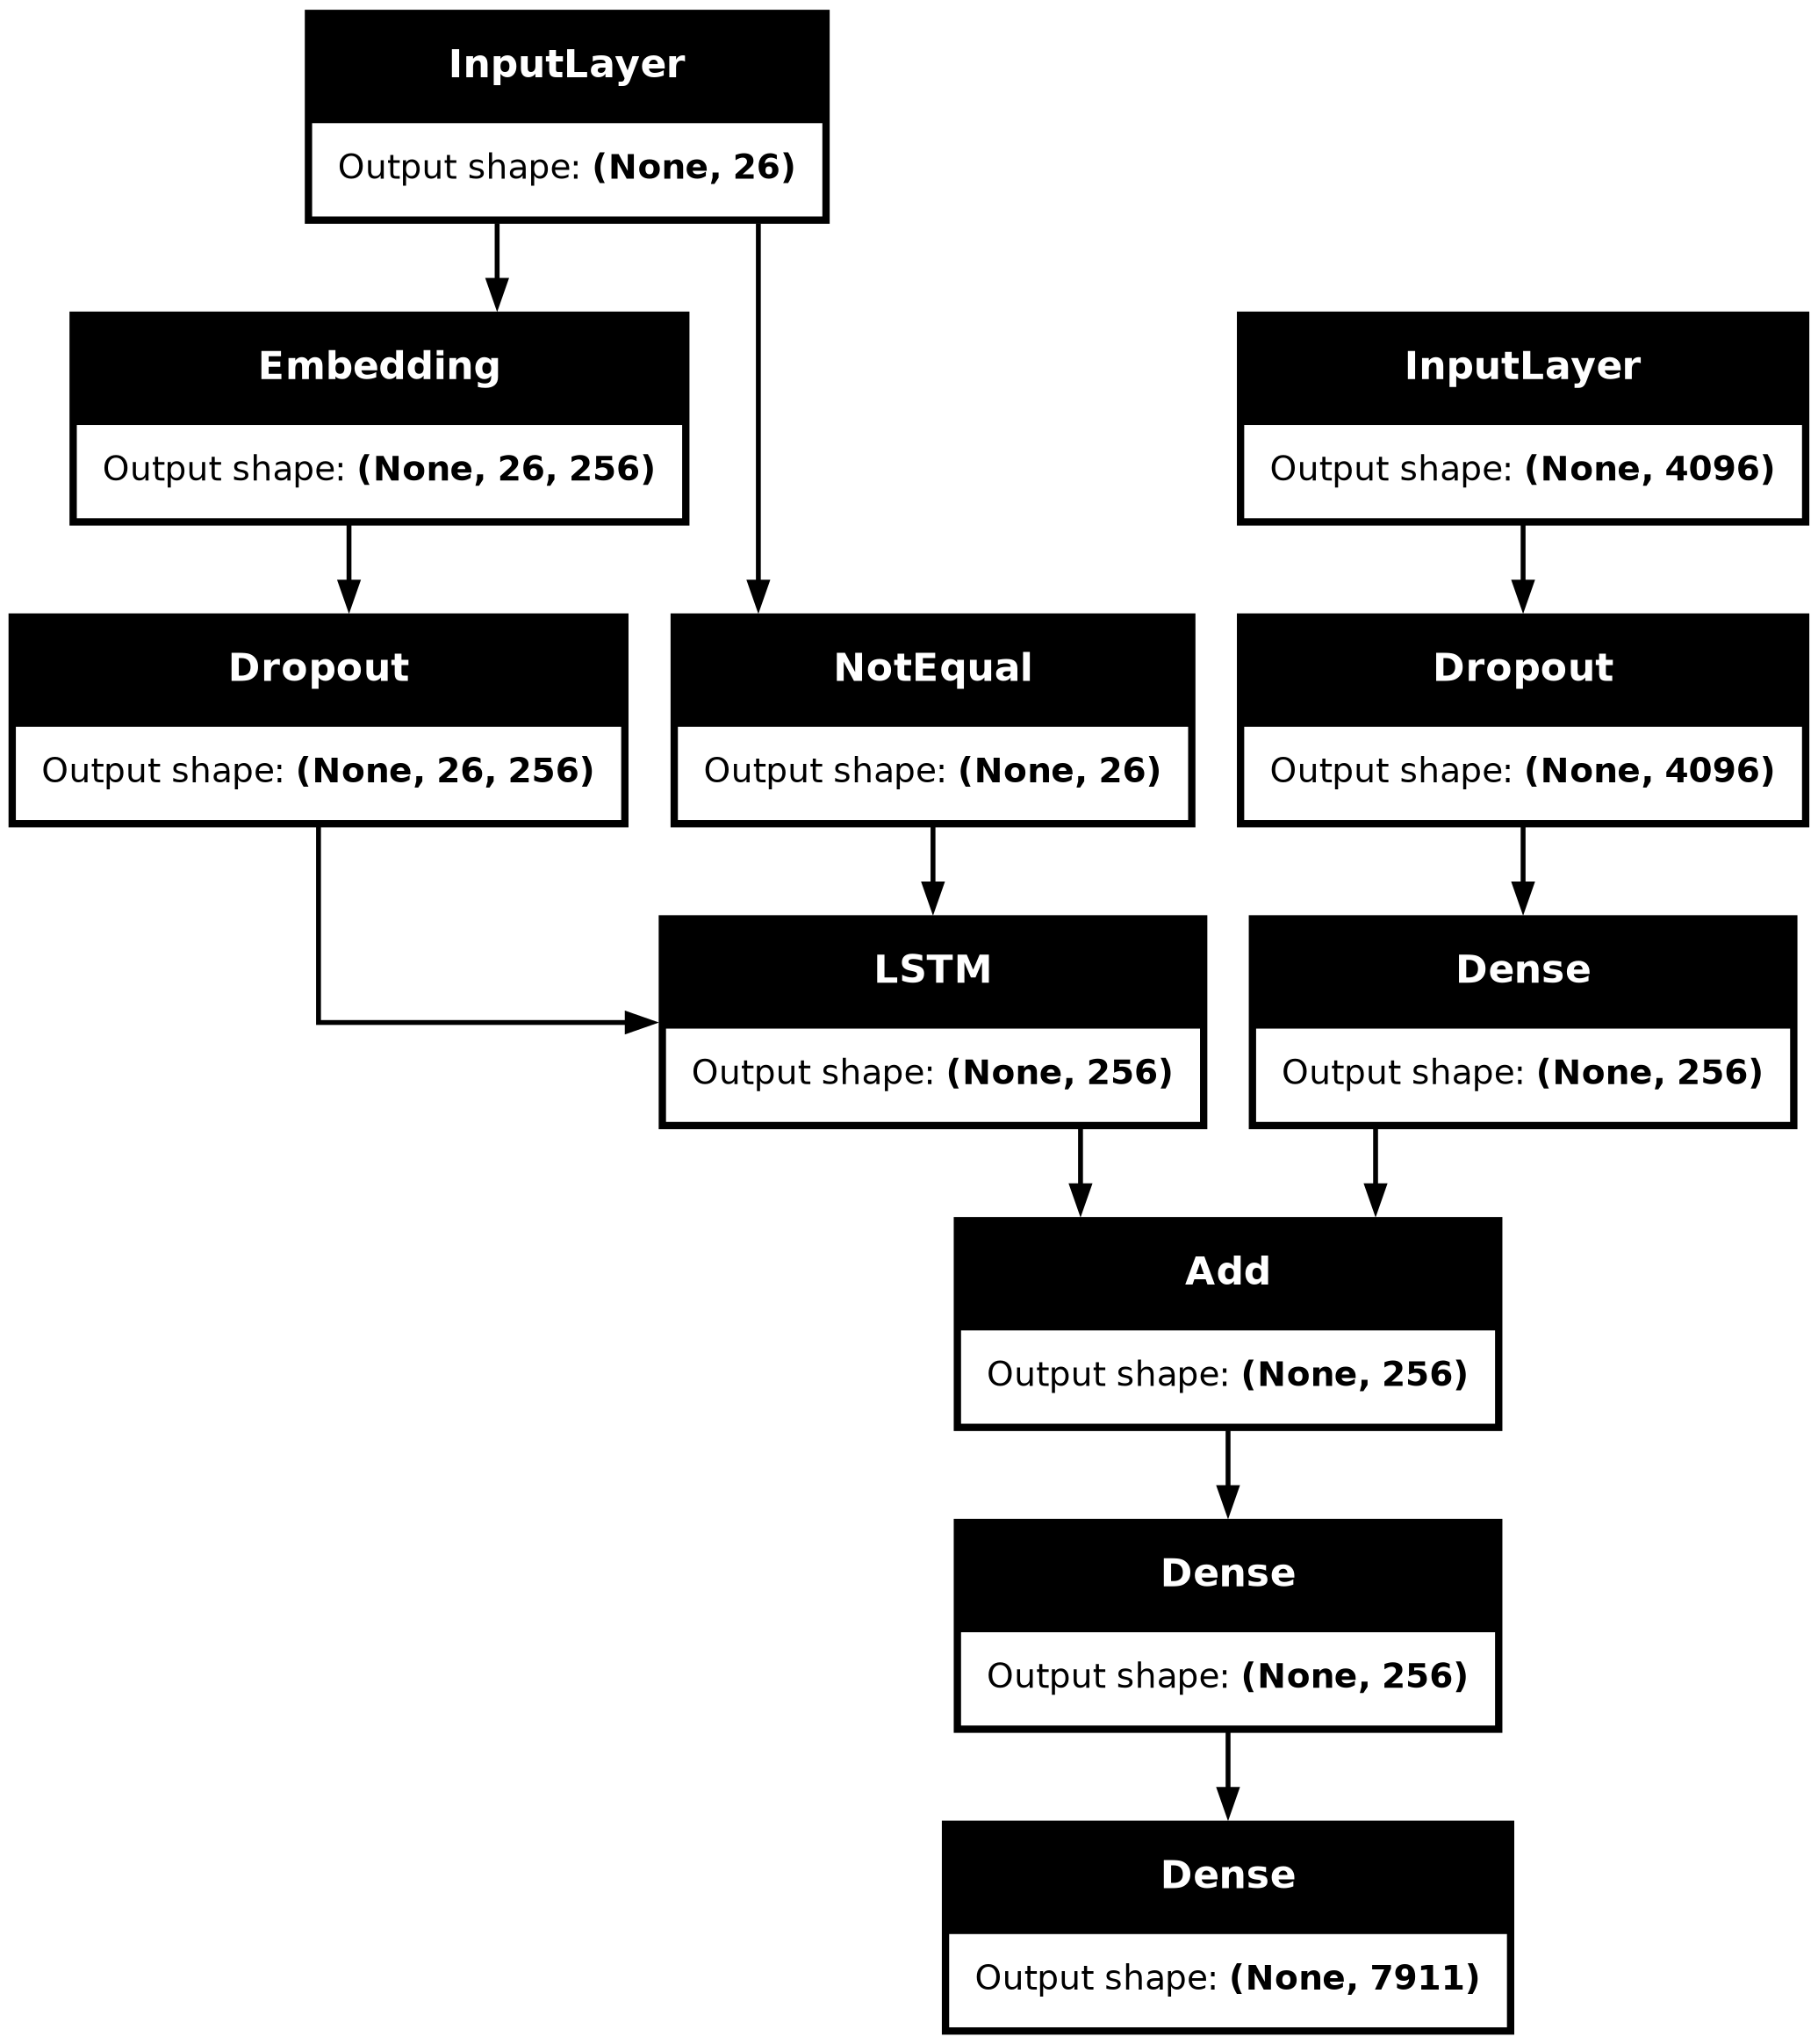

In [54]:
plot_model(model, to_file='model.png', show_shapes=True)

## Training the model

In [22]:
epochs = 8
steps = len(cap_dict_train) // 64

for i in range(epochs):
    generator = data_generator(img_enc, cap_dict_train, tokenizer, max_length=26, vocab_length=vocab_len, batch_size=64)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    

126/126 ━━━━━━━━━━━━━━━━━━━━ 51s 406ms/step - loss: 2.6886
126/126 ━━━━━━━━━━━━━━━━━━━━ 51s 404ms/step - loss: 2.6524
126/126 ━━━━━━━━━━━━━━━━━━━━ 51s 403ms/step - loss: 2.6300
126/126 ━━━━━━━━━━━━━━━━━━━━ 52s 410ms/step - loss: 2.6014
126/126 ━━━━━━━━━━━━━━━━━━━━ 52s 414ms/step - loss: 2.5633
126/126 ━━━━━━━━━━━━━━━━━━━━ 52s 413ms/step - loss: 2.5189
126/126 ━━━━━━━━━━━━━━━━━━━━ 51s 405ms/step - loss: 2.4855
126/126 ━━━━━━━━━━━━━━━━━━━━ 51s 407ms/step - loss: 2.4529


In [23]:
model.save('/kaggle/working/captioning_model.h5')

## Cleaning test data caption and encoding test data images

In [29]:
clean_text(cap_dict_test)

In [30]:
img_enc_test={}
for im in tqdm(list(cap_dict_test.keys())):
    img=image.load_img('/kaggle/input/flickr8k/Images/'+str(im),target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    img_enc_test[im]=vgg_model.predict(x,verbose=0).reshape((4096,))

  0%|          | 0/4274 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1714065252.683305      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 4274/4274 [05:54<00:00, 12.06it/s]


## Model Evaluation

In [31]:
evaluation_generator = data_generator(img_enc_test, cap_dict_test, tokenizer, max_length=26, vocab_length=vocab_len, batch_size=64)
evaluation_steps = len(cap_dict_test) // 64
evaluation_result = model.evaluate(evaluation_generator, steps=evaluation_steps, verbose=1)
print("Evaluation Loss:", evaluation_result)


66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - loss: 4.0584
Evaluation Loss: 4.044835090637207


## Making Inference

In [25]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length=26):
    in_text = 'sos'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([np.array([photo]), np.array(sequence)],verbose=0)
        pred = np.argmax(pred, axis=-1)
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        
        in_text += ' ' + word
        
        if word == 'eos':
            break
        
    return in_text

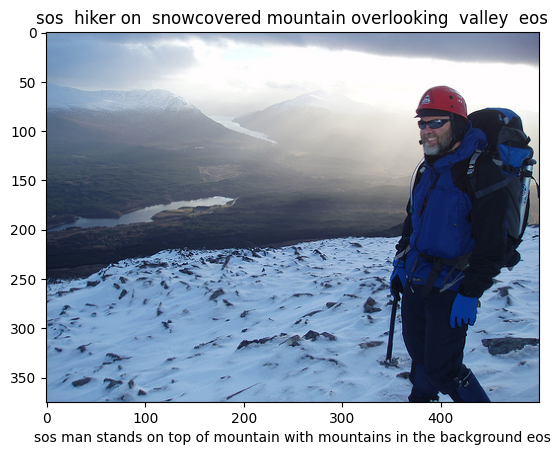

In [52]:
import random
images=list(cap_dict_train.keys())
img=images[random.randint(0,len(images))]

prediction=generate_desc(model, tokenizer, photo=img_enc[img], max_length=26)
plot = plt.imread('/kaggle/input/flickr8k/Images/'+img)
plt.imshow(plot)
plt.title(cap_dict_train[img][0])
plt.xlabel(prediction)
plt.show()